In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
#code to download the dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

#Downloading test data
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


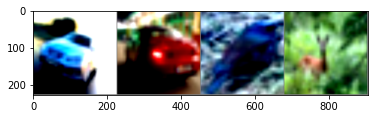

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn.functional as F
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # get the prediction vector
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(torch.nn.Module):
    
    # Compute loss of the given batch and return it
    def compute_batch_loss(self, batch):
        images, labels = batch 
        images, labels = batch[0].to(device), batch[1].to(device)
        
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    # Computes loss and accuracy of the given batch(Used in validation)
    def compute_batch_loss_acc(self, batch):
        images, labels = batch
        images, labels = batch[0].to(device), batch[1].to(device)

        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    # At the end of epoch accumulate all batch loss and batch accueacy    
    def accumulate_batch_loss_acc(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        #print(batch_losses)
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
      # Print in given format 
      # Epoch [0], last_lr: 0.00278, train_loss: 1.2862, val_loss: 1.2110, val_acc: 0.6135
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [6]:
#Model description
import torch.nn as nn
from torchvision import datasets, models, transforms
class ResNet(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.model = models.resnet18(pretrained=True)
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)
    

  def forward(self, x):
    return self.model.forward(x)

In [7]:
ResNet_model = ResNet() 
ResNet_model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
ResNet_model.to(device)

cuda:0


ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [9]:
pytorch_params = sum(p.numel() for p in ResNet_model.parameters())

print("Number of parameters totally = " , pytorch_params)

Number of parameters totally =  11181642


In [ ]:
import torch.optim as optim
import torch.nn as nn

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(ResNet_model.parameters(), lr=0.001, momentum=0.9)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
import time
start_time =  time.time()

# evalute model on validation dataset
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.compute_batch_loss_acc(batch) for batch in data_loader]
    return model.accumulate_batch_loss_acc(outputs)

# Use special scheduler to change the value of learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
  
grad_clip= 1
history=[]
print("Started training")
for epoch in range(10):  # loop over the dataset multiple times
    # print("started")
    running_loss = 0.0
    epoch_loss=[]
    epoch_start_time = time.time()
    lrs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = ResNet_model(inputs)

        # calculate cross entropy loss 
        loss = criterion(output, labels)

        epoch_loss.append(loss)

        #compute the gradient of all weights
        loss.backward()

        # gradient clipping to remove vanishing gradient problem
        nn.utils.clip_grad_value_(ResNet_model.parameters(), grad_clip)

        optimizer.step() # Updates weights 
        
        # lrs.append(get_lr(optimizer))

        running_loss += loss.item()
        # lr_scheduler.step()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
  #  print("Time for finishing this epoch=" , time.time()-epoch_start_time)
    result = evaluate(ResNet_model, testloader)
    result['train_loss'] = torch.stack(epoch_loss).mean().item()
    result['lrs'] = lrs
    history.append(result)

    # ResNet_model.epoch_end(epoch, result)
print(time.time()-start_time)
print('Finished Training of ResNet')

Started training
[1,  2000] loss: 2.304
[1,  4000] loss: 2.246
[1,  6000] loss: 1.440
[1,  8000] loss: 0.876
[1, 10000] loss: 0.736
[1, 12000] loss: 0.642
[2,  2000] loss: 0.523
[2,  4000] loss: 0.492
[2,  6000] loss: 0.461
[2,  8000] loss: 0.436
[2, 10000] loss: 0.430
[2, 12000] loss: 0.414
[3,  2000] loss: 0.301
[3,  4000] loss: 0.319
[3,  6000] loss: 0.320
[3,  8000] loss: 0.318
[3, 10000] loss: 0.331
[3, 12000] loss: 0.309
[4,  2000] loss: 0.222
[4,  4000] loss: 0.223
[4,  6000] loss: 0.226
[4,  8000] loss: 0.240
[4, 10000] loss: 0.233
[4, 12000] loss: 0.231
[5,  2000] loss: 0.160
[5,  4000] loss: 0.178
[5,  6000] loss: 0.172
[5,  8000] loss: 0.186
[5, 10000] loss: 0.190
[5, 12000] loss: 0.195
[6,  2000] loss: 0.141
[6,  4000] loss: 0.163
[6,  6000] loss: 0.151
[6,  8000] loss: 0.155
[6, 10000] loss: 0.147
[6, 12000] loss: 0.144
[7,  2000] loss: 0.091
[7,  4000] loss: 0.118
[7,  6000] loss: 0.125
[7,  8000] loss: 0.117
[7, 10000] loss: 0.126
[7, 12000] loss: 0.134
[8,  2000] loss: 

In [ ]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = ResNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


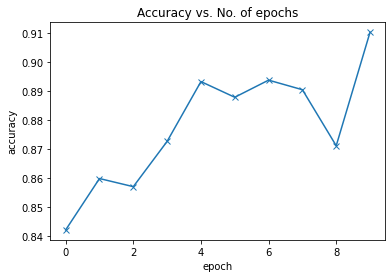

In [ ]:
# Plot Validation accuracy Over Epoch
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

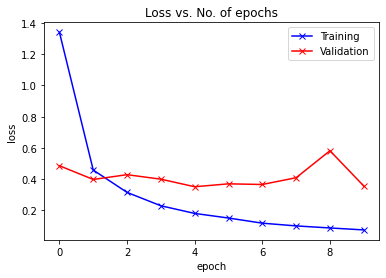

In [ ]:
# Plot training and validation loss to check for overfitting and underfitting
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)